In [1]:
!pip install gensim

# Import

In [9]:
import re
import numpy as np 
import pandas as pd 

pd.set_option('display.max_colwidth', -1)

# dataset
from sklearn.datasets import fetch_20newsgroups

###
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
# Gensim packages
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [3]:
# loading dataset
news_group = fetch_20newsgroups(subset='train')

news_group_data = news_group.data
news_group_target_names = news_group.target_names
news_group_target = news_group.target

In [4]:
# Creating a dataframe from the loaded data
news_df = pd.DataFrame({'desc': news_group_data, 
                        'class': news_group_target})

In [5]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   desc    11314 non-null  object
 1   class   11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


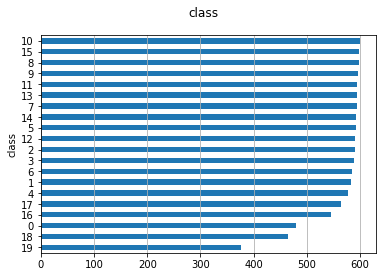

In [6]:
import matplotlib.pyplot as plt

x = "class"

fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
news_df[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# Custom filter method
transform_to_lower = lambda s: s.lower() #upper to lower case

remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s) #regex to remove single char

# Filters to be executed in pipeline
CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char,stem_text] #stemming text

# Method does the filtering of all the unrelevant text elements
def cleaning_pipe(document):
    # Invoking gensim.parsing.preprocess_string method with set of filters
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words
news_df['desc'] = news_df['desc'].apply(cleaning_pipe)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(news_df, test_size=0.1)
train_data = train_df["desc"]
train_target = train_df["class"]
test_data = test_df["desc"]
test_target = test_df["class"]

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
import spacy 
from sklearn.base import BaseEstimator, TransformerMixin
nlp = spacy.load("en_core_web_md")  # this model will give you 300D

class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        return [self.nlp(text).vector for text in X]

In [ ]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier()),
    ])
embeddings_pipeline.fit(train_data, train_target)
y_pred = embeddings_pipeline.predict(test_data)

In [ ]:
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.57      0.53      0.55        49
           1       0.58      0.51      0.54        75
           2       0.57      0.55      0.56        58
           3       0.62      0.56      0.59        64
           4       0.48      0.41      0.44        59
           5       0.59      0.73      0.65        60
           6       0.62      0.83      0.71        53
           7       0.78      0.66      0.71        64
           8       0.59      0.67      0.63        57
           9       0.74      0.84      0.79        62
          10       0.73      0.75      0.74        63
          11       0.74      0.81      0.77        48
          12       0.79      0.52      0.62        64
          13       0.80      0.80      0.80        55
          14       0.64      0.87      0.74        52
          15       0.68      0.75      0.71        68
          16       0.61      0.76      0.67        49
   

In [ ]:
segment_featurizer = SegmentFeaturizer()  # more on this below
def get_n_words_before_main_verb(doc):
    numbers = [0]
    for sent in doc.sents:
        main = [t for t in sent if t.dep_ == "ROOT"][0]  # every doc has a root token
        if main.pos_ == "VERB":
            dist_to_init = main.i - sent[0].i
            numbers.append(dist_to_init)
    return np.mean(numbers)
class CustomLinguisticFeatureTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
        pass    
  def fit(self, x, y=None):
        return self 
  def transform(self, data):
        return segment_featurizer.featurize(data)
        
class SegmentFeaturizer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_md")
        self.future_words = ["tomorrow", "future", "futures"]
    
    @staticmethod
    def count_pronouns(doc):
        segment = doc.text.lower().split()
        counter = {"1sg": 0, "1pl": 0}
        for pronoun in FIRST_SINGULAR:
            counter["1sg"] += segment.count(pronoun)
        for pronoun in FIRST_PLURAL:
            counter["1pl"] += segment.count(pronoun)
        return counter
   
    def get_sent_length_stats(doc):
      token_counts = [len(sent) for sent in doc.sents]
      sent_length_dict = {
          "segment_length": len(doc),
          "n_sents": len(list(doc.sents)),
          "mean_sent_length": np.mean(token_counts),
          "std_sent_length": np.std(token_counts),
      }
      return sent_length_dict

    def get_n_future_oriented_words(self, doc):
        will_aux = [t for t in doc if t.tag_ == "MD" and t.lower_ in {"will", "wo", "shall", "sha"}]
        going_to = [t for t in doc if t.dep_ == "xcomp" and t.head.lemma_ == "go"]
        other_future_words = [t for t in doc if t.lower_ in self.future_words]
        return len(will_aux) + len(going_to) + len(other_future_words)

    

    @staticmethod
    def get_n_words_before_main_verb(doc):
        numbers = [0]
        for sent in doc.sents:
            main = [t for t in sent if t.dep_ == "ROOT"][0]
            if main.pos_ == "VERB":
                dist_to_init = main.i - sent[0].i
                numbers.append(dist_to_init)
        return np.mean(numbers)

    @staticmethod
    def get_n_complex_clauses(doc):
        embedded_elements_count = []
        for sent in doc.sents:
            n_embedded = len(
                [t for t in sent if t.dep_ in {"ccomp", "xcomp", "advcl", "dative"}]
            )
            embedded_elements_count.append(n_embedded)
        return np.mean(embedded_elements_count)
    
    # putting it all together!
    def featurize(self, segments):
        feature_dicts = []
        docs = self.nlp.pipe(segments)
        for doc in docs:
            feature_dict = {
                "n_future_oriented_words": self.get_n_future_oriented_words(doc),
                "n_words_before_main_verb": self.get_n_words_before_main_verb(doc),
                "n_complex_clauses": self.get_n_complex_clauses(doc),
                "mean_sent_length": self.get_sent_length_stats(doc)["mean_sent_length"],
            }
            feature_dicts.append(feature_dict)
        return feature_dicts

In [ ]:
manual_pipeline = Pipeline(
    steps=[
        ("stats", CustomLinguisticFeatureTransformer()),
        ("dict_vect", DictVectorizer()),
        ("classifier", RandomForestClassifier()),
    ]
)
manual_pipeline.fit(train_data, train_target)
y_pred = manual_pipeline.predict(test_data)
cr = classification_report(test_target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

In [12]:
#BOW pipeline
bow_pipeline = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ("classifier", RandomForestClassifier()),
    ]
)
bow_pipeline.fit(train_data, train_target)
y_pred = bow_pipeline.predict(test_data)
cr = classification_report(test_target, y_pred)
print('Classification report:\n\n{}'.format(
    classification_report(test_target, y_pred))
)

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        56
           1       0.68      0.81      0.73        67
           2       0.68      0.91      0.78        57
           3       0.76      0.66      0.71        68
           4       0.81      0.86      0.84        65
           5       0.88      0.86      0.87        65
           6       0.71      0.88      0.79        50
           7       0.74      0.79      0.77        62
           8       0.92      0.86      0.89        65
           9       0.85      0.92      0.88        61
          10       0.91      0.94      0.93        54
          11       0.94      0.94      0.94        53
          12       0.86      0.67      0.75        57
          13       0.91      0.79      0.85        52
          14       0.89      0.82      0.85        60
          15       0.72      0.89      0.79        54
          16       0.88      0.90      0.89        58
   

In [ ]:
news_df['word_count'] = news_df["desc"].apply(lambda x: len(str(x).split(" ")))
news_df['char_count'] = news_df["desc"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
news_df['sentence_count'] = news_df["desc"].apply(lambda x: len(str(x).split("\n")))
news_df['avg_word_length'] = news_df['char_count'] / news_df['word_count']
news_df['avg_sentence_lenght'] = news_df['word_count'] / news_df['sentence_count']
news_df.head()

### Pre-Processing

In [ ]:
# "\s"	Most engines: "whitespace character": space, tab, newline, carriage return,
# "\w" means "any word character" which usually means alphanumeric (letters, numbers, regardless of case) plus underscore (_)
# more info https://www.rexegg.com/regex-quickstart.html

In [ ]:
# Custom filter method
transform_to_lower = lambda s: s.lower() #upper to lower case

remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s) #regex to remove single char

# Filters to be executed in pipeline
CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char,stem_text] #stemming text

# Method does the filtering of all the unrelevant text elements
def cleaning_pipe(document):
    # Invoking gensim.parsing.preprocess_string method with set of filters
    processed_words = preprocess_string(document, CLEAN_FILTERS)
    
    return processed_words

In [ ]:
# Apply the cleaning pipe on the news data

news_extracts['clean_text'] = news_extracts['desc'].apply(cleaning_pipe)
news_extracts['clean_text'][0:2]

0    [mailrp, esa, bitnet, vm, gmd, subject, messag, space, digestad, forward, space, digest, organ, intern, space, univers, origin, sender, isu, vacat, venari, cs, cmu, edu, distribut, sci, line, press, releas, pari, april, user, esaolympu, satellit, report, outcom, experi, todai, europespac, telecommun, sector, blossom, olympu, provid, testb, technolog, servicessummaris, gener, conclus, speaker, particip, confer, olympu, utilis, held, sevil, april, confer, organis, european, space, agenc, esa, spanish, centr, develop, industri, technolog, cdti, olympu, particularli, us, bring, satellit, telecommun, thousand, new, user, thank, satellit, termin, small, antenna, vsat, olympu, experi, test, data, transmiss, videoconferenc, busi, televis, distanc, teach, rural, telephoni, exampl, open, door, new, ...]
1    [wilson, swee, subject, compil, sun, organ, junior, math, scienc, carnegi, mellon, pittsburgh, pa, line, nntp, post, host, po, andrew, cmu, edu, hi, piececod, compil, fine, pmax, ul, pm

In [ ]:
print(news_extracts['clean_text'][0:10])
print(news_extracts['class'][0:10])

0    [cbrook, ms, uki, edu, clayton, brook, subjectmax, handl, request, organ, univers, kentucki, dept, math, scienc, line, bradw, newbridg, com, brad, warkentin, write, serious, handl, probabl, good, big, standard, earlycompar, what, state, art, dai, think, littl, opinion, come, ride, cbgskzv, max, enjoy, ridingmax, fast, twisti, road, claytonbrook, heart, cbrook, ms, uki, edu, poto, ky, blue, cbrook, ukma, bitnet, lex, ky, grass, rutger, uunet, ukma, cbrook, bourbon, countri, ama, nma, maa, am, acbl, dod]                                                                                                                                                                                                                                                        
1    [jcm, head, cfa, harvard, edu, jonathan, mcdowel, subject, shuttl, launch, question, organ, smithsonian, astrophys, observatori, cambridg, ma, usa, distribut, sci, line, articl, tombak, world, std, com, tom, baker, articl, etrat, ttac

## Bag of Words

In [ ]:
from gensim import corpora

dictionary = corpora.Dictionary(news_extracts['clean_text'])
print(dictionary)

Dictionary(35132 unique tokens: ['acbl', 'am', 'ama', 'art', 'big']...)


In [ ]:
print(dictionary.token2id)

{'acbl': 0, 'am': 1, 'ama': 2, 'art': 3, 'big': 4, 'bitnet': 5, 'blue': 6, 'bourbon': 7, 'brad': 8, 'bradw': 9, 'brook': 10, 'cbgskzv': 11, 'cbrook': 12, 'clayton': 13, 'claytonbrook': 14, 'com': 15, 'come': 16, 'countri': 17, 'dai': 18, 'dept': 19, 'dod': 20, 'earlycompar': 21, 'edu': 22, 'enjoy': 23, 'fast': 24, 'good': 25, 'grass': 26, 'handl': 27, 'heart': 28, 'kentucki': 29, 'ky': 30, 'lex': 31, 'line': 32, 'littl': 33, 'maa': 34, 'math': 35, 'max': 36, 'ms': 37, 'newbridg': 38, 'nma': 39, 'opinion': 40, 'organ': 41, 'poto': 42, 'probabl': 43, 'request': 44, 'ride': 45, 'ridingmax': 46, 'road': 47, 'rutger': 48, 'scienc': 49, 'serious': 50, 'standard': 51, 'state': 52, 'subjectmax': 53, 'think': 54, 'twisti': 55, 'uki': 56, 'ukma': 57, 'univers': 58, 'uunet': 59, 'warkentin': 60, 'what': 61, 'write': 62, 'arenset': 63, 'articl': 64, 'astrophys': 65, 'baker': 66, 'basic': 67, 'bug': 68, 'cambridg': 69, 'caution': 70, 'cfa': 71, 'checkedright': 72, 'clear': 73, 'code': 74, 'condit':

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(news_extracts['clean_text'], min_count=1)

In [ ]:
print(model)

Word2Vec(vocab=35132, size=100, alpha=0.025)


# LDA

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaModel
# Create a corpus from a list of texts
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20)

In [ ]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.test.utils import datapath
common_dictionary = Dictionary(common_texts)
other_corpus = [common_dictionary.doc2bow(text) for text in news_extracts['clean_text']]

In [ ]:
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=20)
# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

In [ ]:
unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document
print(vector)

[(0, 0.05), (1, 0.05), (2, 0.05), (3, 0.05), (4, 0.05), (5, 0.05), (6, 0.05), (7, 0.05), (8, 0.05), (9, 0.05), (10, 0.05), (11, 0.05), (12, 0.05), (13, 0.05), (14, 0.05), (15, 0.05), (16, 0.05), (17, 0.05), (18, 0.05), (19, 0.05)]


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (1, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in news_df.iterrows():
    vectors.append(", ".join(row[1]))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

AttributeError: ignored

In [ ]:
news_df.drop(columns='class', inplace=True)


In [ ]:
news_df = news_df.reset_index(drop=True, inplace=True)